In [1]:
import rasterio
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
from rasterio.transform import rowcol
import pandas as pd
from whitebox import WhiteboxTools
from skimage.morphology import skeletonize, remove_small_objects
from scipy.ndimage import label
from skimage.measure import regionprops
import plotly.graph_objects as go
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
from itertools import combinations
import pickle
from datetime import datetime, timedelta
import ee
ee.Initialize(project="ee-azizagrebi4")

In [ ]:
dem_country = "Burkina" # Pays sur lequel on va travailler ici
accum_threshold = 500 # Seuil sur l'accumulation
ridge_size = 30 # Seuil utiliser pour identifier les crêtes
i, j = 3, 4 # On va diviser le grand .tif qui ne charge pas en ram en plusieurs sous-parties sous la forme d'un quadrillage. 
            # i et j indiquent sur quelle sous-partie du quadrillage on va travailler.

In [ ]:
dem_to_inference = {
    "Benin": "Benin",
    "Burkina": "BF",
    "Guinee": "gui",
    "Mali": "Mali",
    "Niger": "Niger",
    "Togo": "Togo",
} # Simple dictionnaire utilisé pour faire la correspondance entre les différents noms de mes fichiers. Inutile pour vous à priori.

inference_country = dem_to_inference[dem_country]

with rasterio.open(f"DEM/{dem_country}/{dem_country}.tif") as src: # On ouvre le fichier .tif pour avoir ses propriétés
    transform = src.transform
    area = src.read(1)
    width = src.width
    height = src.height

max_width = 5000 # Largeur d'une sous-partie du quadrillage
max_height = 5000 # Hauteur d'une sous-partie du quadrillage
padding = 100 # On ajoute à chaque sous-partie du quadrillage un léger recouvrement sur les parties voisines pour éviter les effets de bords dans les calculs.

i_max, j_max = height // max_height + int(height % max_height != 0), width // max_width + int(width % max_width != 0)
print(i_max, j_max)

6 7


In [ ]:
row_min = max(0, i * max_height)
col_min = max(0, j * max_width)
row_max = min(height, row_min + max_height)
col_max = min(width, col_min + max_width)

with rasterio.open(f"DEM/{dem_country}/{dem_country}.tif") as src: # On charge et sauvegarde la sous-partie du quadrillage sur laquelle on veut travailler.
    transform = src.transform
    window = rasterio.windows.Window(max(0, col_min - padding), 
                                    max(0, row_min - padding), 
                                    (col_min - max(0, col_min - padding)) + col_max - col_min + (min(width, col_max + padding) - col_max), 
                                    (row_min - max(0, row_min - padding)) + row_max - row_min + (min(height, row_max + padding) - row_max))
    dem = src.read(1, window=window)

    results = []

    output_path = f"Temporary_dem_{dem_country}_{i}_{j}.tif"

    new_transform = src.window_transform(window)

    new_meta = src.meta.copy()
    new_meta.update({
        "height": dem.shape[0], 
        "width": dem.shape[1],
        "transform": new_transform
    })

    with rasterio.open(output_path, "w", **new_meta) as dst:
        dst.write(dem, 1)

wbt = WhiteboxTools() # whitebox est la librairie qui nous permet de calculer les features topographiques. Vous pouvez vous référer à la doc pour comprendre
                      # les fonctions suivantes. NB : pour charger et écrire les fichiers la librairie semble fonctionner avec les chemins absolus des fichiers.

wbt.fill_depressions(
    f"C:/Users/aziza/Desktop/Map/Temporary_dem_{dem_country}_{i}_{j}.tif", 
    f"C:/Users/aziza/Desktop/Map/Temporary_filled_dem_{dem_country}_{i}_{j}.tif"
)

wbt.gaussian_filter(
    i=f"C:/Users/aziza/Desktop/Map/Temporary_filled_dem_{dem_country}_{i}_{j}.tif",
    output=f"C:/Users/aziza/Desktop/Map/Temporary_smoothed_dem_{dem_country}_{i}_{j}.tif",
    sigma=4.0
)

wbt.d8_flow_accumulation(
    f"C:/Users/aziza/Desktop/Map/Temporary_smoothed_dem_{dem_country}_{i}_{j}.tif", 
    f"C:/Users/aziza/Desktop/Map/Temporary_flow_accum_{dem_country}_{i}_{j}.tif", out_type="cells"
)

wbt.extract_streams(
    f"C:/Users/aziza/Desktop/Map/Temporary_flow_accum_{dem_country}_{i}_{j}.tif", 
    f"C:/Users/aziza/Desktop/Map/Temporary_streams_{dem_country}_{i}_{j}.tif", 
    threshold=accum_threshold
)

wbt.geomorphons(
    f"C:/Users/aziza/Desktop/Map/Temporary_smoothed_dem_{dem_country}_{i}_{j}.tif",
    f"C:/Users/aziza/Desktop/Map/Temporary_geomorphons_{dem_country}_{i}_{j}.tif",
)

wbt.slope(
    f"C:/Users/aziza/Desktop/Map/Temporary_smoothed_dem_{dem_country}_{i}_{j}.tif",
    f"C:/Users/aziza/Desktop/Map/Temporary_slope_{dem_country}_{i}_{j}.tif",
)

wbt.profile_curvature(
    f"C:/Users/aziza/Desktop/Map/Temporary_smoothed_dem_{dem_country}_{i}_{j}.tif",
    f"C:/Users/aziza/Desktop/Map/Temporary_curvature_{dem_country}_{i}_{j}.tif",  
)

with rasterio.open(f"C:/Users/aziza/Desktop/Map/Temporary_smoothed_dem_{dem_country}_{i}_{j}.tif") as src: # On garde en mémoire les transformations qui permettent de passer
    new_transform = src.transform                                                                          # de coordonnées arrays à coordonnées (lon, lat) et vis-versa.
    new_width = src.width
    new_height = src.height
    smoothed_dem = src.read(1)
    cols, rows = np.meshgrid(np.arange(new_width), np.arange(new_height))
    longitudes, latitudes = rasterio.transform.xy(
        new_transform, rows, cols, offset='center'
    )
    longitudes = np.array(longitudes).reshape(smoothed_dem.shape)
    latitudes = np.array(latitudes).reshape(smoothed_dem.shape)

with rasterio.open(f"C:/Users/aziza/Desktop/Map/Temporary_streams_{dem_country}_{i}_{j}.tif") as dataset:
    streams = dataset.read(1)

with rasterio.open(f"C:/Users/aziza/Desktop/Map/Temporary_slope_{dem_country}_{i}_{j}.tif") as dataset:
    grad = dataset.read(1)

with rasterio.open(f"C:/Users/aziza/Desktop/Map/Temporary_curvature_{dem_country}_{i}_{j}.tif") as dataset:
    hessian = dataset.read(1)

with rasterio.open(f"C:/Users/aziza/Desktop/Map/Temporary_geomorphons_{dem_country}_{i}_{j}.tif") as dataset: # On utilise geomorphons pour filtrer/détecter les crêtes
    band1 = dataset.read(1)                                                                                   # des bassins versants.
    band1 = np.maximum(band1, 0)

    mask_black = band1 < 4
    labeled_array, num_features = label(mask_black)

    filtered_mask = np.zeros_like(mask_black)

    for region in regionprops(labeled_array):
        if region.area >= ridge_size:
            for coord in region.coords:
                filtered_mask[coord[0], coord[1]] = 1

    ridges = band1 * filtered_mask

    ridges = np.minimum(ridges, 1)

    binary_ridges = ridges > 0

    thin_ridges = skeletonize(binary_ridges)

    ridges = thin_ridges.astype(int)

    thin_ridges_cleaned = remove_small_objects(ridges.astype(bool), min_size=2)

    ridges = thin_ridges_cleaned.astype(int)

.\whitebox_tools.exe --run="FillDepressions" --dem='C:/Users/aziza/Desktop/Map/Temporary_dem_Burkina_3_4.tif' --output='C:/Users/aziza/Desktop/Map/Temporary_filled_dem_Burkina_3_4.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 8%
Finding pit cells: 16%
Finding pit cells: 25%
Finding pit cells: 33%
Finding pit cells: 41%
Finding pit cells: 50%
Finding pit cells: 58%
Finding pit cells: 66%
Finding pit cells: 75%
Finding pit cells: 83%
Finding pit cells: 91%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depr

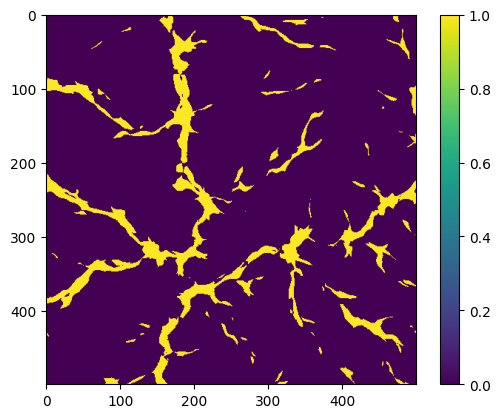

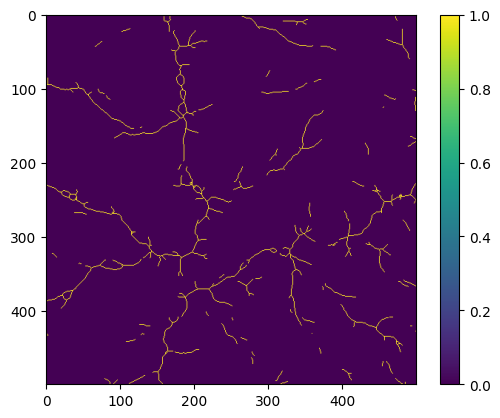

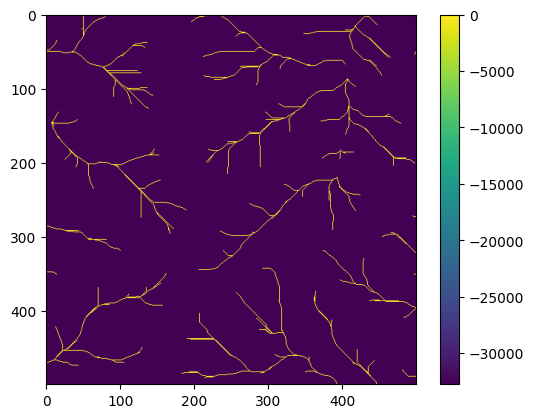

In [53]:
with rasterio.open(f"C:/Users/aziza/Desktop/Map/Temporary_geomorphons_{dem_country}_{i}_{j}.tif") as dataset:
    band1 = dataset.read(1)
    band1 = np.maximum(band1, 0)

    mask_black = band1 < 4
    labeled_array, num_features = label(mask_black)

    filtered_mask = np.zeros_like(mask_black)

    for region in regionprops(labeled_array):
        if region.area >= 5:
            for coord in region.coords:
                filtered_mask[coord[0], coord[1]] = 1

    ridges = band1 * filtered_mask

    ridges = np.minimum(ridges, 1)

    binary_ridges = ridges > 0

    thin_ridges = skeletonize(binary_ridges)

    ridges = thin_ridges.astype(int)

    thin_ridges_cleaned = remove_small_objects(ridges.astype(bool), min_size=1)

    ridges = thin_ridges_cleaned.astype(int)

plt.imshow(band1[2000: 2500, 2000: 2500] < 4)
plt.colorbar()
plt.show()
plt.imshow(ridges[2000: 2500, 2000: 2500])
plt.colorbar()
plt.show()
plt.imshow(streams[2000: 2500, 2000: 2500])
plt.colorbar()
plt.show()

In [41]:
df_topo = pd.read_csv(f"Topo_features_{dem_country}_500_30_{i}_{j}.csv", index_col=0)
df_topo = df_topo.drop(["OMES_ID", "LON", "LAT", "DATE", "NS", "precipitation", "ndvi"], axis=1).dropna(axis=0)
df_meteo = pd.read_csv(f"Meteo_features_{dem_country}.csv", index_col=0)
df = pd.concat([df_meteo, df_topo], axis=1).dropna(axis=0)
df.shape

(132, 60)

In [54]:
num = 10

In [ ]:
#Visuel 3D avec le point d'intérêt, le stream point et le ridge point associés. On affiche ici notre région en 3D de façon interactive.

index = df.index[num]
lon, lat = df.loc[index, "LON"], df.loc[index, "LAT"]
row_point, col_point = rowcol(new_transform, lon, lat)
stream_point_row, stream_point_col = int(df.loc[index, "stream_row"]), int(df.loc[index, "stream_col"])
ridge_point_row, ridge_point_col = int(df.loc[index, "ridge_row"]), int(df.loc[index, "ridge_col"])

data = smoothed_dem[row_point - padding:row_point + padding, col_point - padding:col_point + padding]
tronc_streams = streams[row_point - padding:row_point + padding, col_point - padding:col_point + padding]
tronc_ridges = ridges[row_point - padding:row_point + padding, col_point - padding:col_point + padding]

x = np.arange(data.shape[1])
y = np.arange(data.shape[0])

X, Y = np.meshgrid(x, y)

streams_row, streams_col = np.where(tronc_streams == 1)
streams_z = data[streams_row, streams_col]

ridges_row, ridges_col = np.where(tronc_ridges == 1)
ridges_z = data[ridges_row, ridges_col]

fig = go.Figure(data=[
    go.Surface(z=data, x=X, y=Y, colorscale="Viridis", showscale=True)
])

fig.add_trace(go.Scatter3d(
    x=streams_col, 
    y=streams_row, 
    z=streams_z, 
    mode='markers',  
    marker=dict(size=2, color='blue', symbol='circle')
))

fig.add_trace(go.Scatter3d(
    x=ridges_col, 
    y=ridges_row, 
    z=ridges_z, 
    mode='markers',  
    marker=dict(size=2, color='red', symbol='circle')
))

fig.add_trace(go.Scatter3d(
    x=[padding], 
    y=[padding], 
    z=[smoothed_dem[row_point, col_point]], 
    mode='markers',  
    marker=dict(size=5, color='black', symbol='circle')
))

fig.add_trace(go.Scatter3d(
    x=[padding], 
    y=[padding], 
    z=[smoothed_dem[row_point, col_point] - df.loc[index, "NS"]], 
    mode='markers',  
    marker=dict(size=5, color='Yellow', symbol='circle'),
    text=f"NS: {df.loc[index, 'NS']}"
))

fig.add_trace(go.Scatter3d(
    x=[stream_point_col - col_point + padding], 
    y=[stream_point_row - row_point + padding], 
    z=[smoothed_dem[stream_point_row, stream_point_col]], 
    mode='markers',  
    marker=dict(size=5, color='black', symbol='circle')
))

fig.add_trace(go.Scatter3d(
    x=[ridge_point_col - col_point + padding], 
    y=[ridge_point_row - row_point + padding], 
    z=[smoothed_dem[int(ridge_point_row), int(ridge_point_col)]], 
    mode='markers',  
    marker=dict(size=5, color='black', symbol='circle')
))

fig.update_layout(
    title="3D Surface Plot avec Crêtes",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Élévation"
    ),
    autosize=False,
    scene_aspectmode='data'
)

fig.show()

In [ ]:
os.remove(f"Temporary_dem_{dem_country}_{i}_{j}.tif")
os.remove(f"Temporary_filled_dem_{dem_country}_{i}_{j}.tif")
os.remove(f"Temporary_smoothed_dem_{dem_country}_{i}_{j}.tif")
os.remove(f"Temporary_flow_accum_{dem_country}_{i}_{j}.tif")
os.remove(f"Temporary_streams_{dem_country}_{i}_{j}.tif")
os.remove(f"Temporary_geomorphons_{dem_country}_{i}_{j}.tif")
os.remove(f"Temporary_slope_{dem_country}_{i}_{j}.tif")